beta estimado:  0.9761
gamma estimado: 0.5559
R_0 estimado:   1.7560


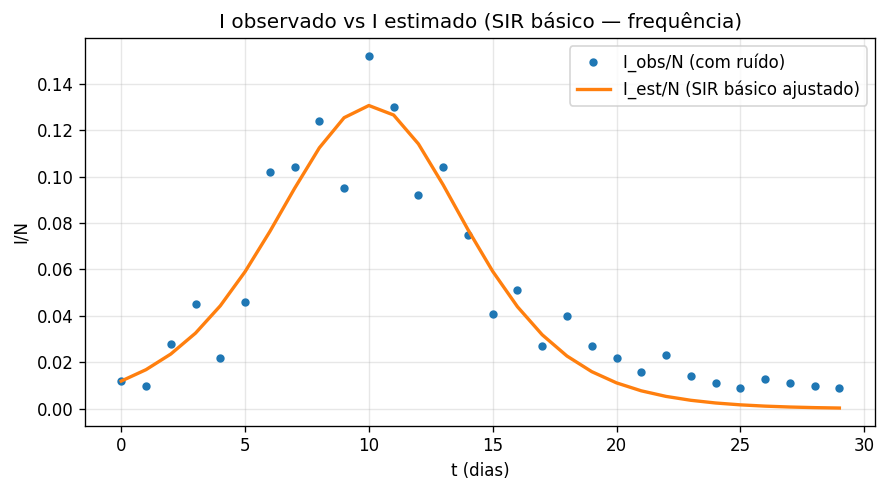

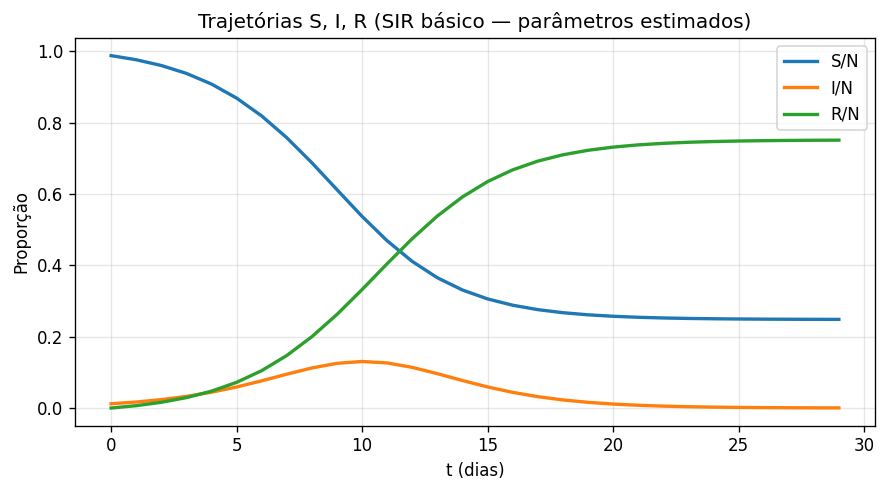

In [ ]:
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# AJUSTE DE PARÂMETROS NO MODELO SIR DISCRETO BÁSICO (EULER)
# Transmissão dependente da frequência (incidência ~ S*I/N)
#
# Atualização diária (Dt = 1):
#   S[t+1] = S[t] - beta  * S[t] * I[t] / N
#   I[t+1] = I[t] + (beta * S[t] * I[t] / N - gamma * I[t])
#   R[t+1] = R[t] + gamma * I[t]
#
# Objetivo: estimar (beta, gamma) a partir de observações de I(t),
# minimizando o erro quadrático
# ============================================================


def sir_basico(params, S0, I0, R0, N, dias):
    """
    Simula o SIR discreto básico (passo diário) e retorna apenas I(t),
    pois o ajuste usa somente a série observada de infectados.

    params = (beta, gamma)
    S0, I0, R0: condições iniciais
    N: população total (constante)
    dias: número de pontos (por exemplo, len(I_obs))
    """
    beta, gamma = params

    # Vetores para armazenar a trajetória (valores reais, mesmo que representem contagens)
    S = np.zeros(dias, dtype=float)
    I = np.zeros(dias, dtype=float)
    R = np.zeros(dias, dtype=float)

    # Estado inicial
    S[0], I[0], R[0] = S0, I0, R0

    # Iteração do modelo em tempo discreto
    for t in range(dias - 1):
        # Incidência (novas infecções no dia t): beta * S[t] * I[t] / N
        # Remoções (recuperações) no dia t: gamma * I[t]
        S[t+1] = S[t] - beta * S[t] * I[t] / N
        I[t+1] = I[t] + (beta * S[t] * I[t] / N - gamma * I[t])
        R[t+1] = R[t] + gamma * I[t]

        # Correção mínima: evita valores negativos de I por efeitos numéricos
        if I[t+1] < 0:
            I[t+1] = 0.0

    # Para o ajuste, retornamos somente a série prevista de infectados
    return I


def sir_basico_full(params, S0, I0, R0, N, dias):
    """
    Mesma simulação do SIR básico, mas retornando (S, I, R).
    Útil para plotar as trajetórias após estimar os parâmetros.
    """
    beta, gamma = params

    S = np.zeros(dias, dtype=float)
    I = np.zeros(dias, dtype=float)
    R = np.zeros(dias, dtype=float)

    S[0], I[0], R[0] = S0, I0, R0

    for t in range(dias - 1):
        S[t+1] = S[t] - beta * S[t] * I[t] / N
        I[t+1] = I[t] + (beta * S[t] * I[t] / N - gamma * I[t])
        R[t+1] = R[t] + gamma * I[t]

        if I[t+1] < 0:
            I[t+1] = 0.0

    return S, I, R

# Função objetivo para mínimos quadrados
def objetivo(params, I_obs, S0, I0, R0, N):
    I_pred = sir_basico(params, S0, I0, R0, N, len(I_obs))
    return np.sum((I_pred - I_obs) ** 2)

# Séries base + ruído (para simular dados reais)
# Série base:
I_b = np.array([10, 15, 23, 35, 52, 75, 98, 115, 125, 128, 120, 105,
                   90, 78, 66, 55, 46, 38, 32, 27, 23, 20, 17, 15,
                   13, 11, 10, 9, 8, 7])

# População total (constante no modelo)
N = 1000

# Gerador pseudoaleatório com semente fixa (reprodutibilidade no artigo)
rng = np.random.default_rng(42)

# Ruído heterocedástico: a variância cresce com o nível de I
# (dados epidemiológicos reais raramente têm erro constante)
noise_frac = 0.30
noise_sd = np.maximum(5, noise_frac * I_b)  # desvio-padrão mínimo de 5

# Série observada: soma ruído e arredonda para contagens inteiras
I_obs = np.rint(I_b + rng.normal(0.0, noise_sd)).astype(int)

# Garante que 0 ≤ I_obs ≤ N (não existem contagens negativas nem maiores que N)
I_obs = np.clip(I_obs, 0, N)

# Condições iniciais consistentes com os dados observados no dia 0
S0, I0, R0 = N - I_obs[0], I_obs[0], 0

# Eixo do tempo (dias discretos)
t = np.arange(len(I_obs))


# -------------------------------------------------------------------
# OTIMIZAÇÃO: estima beta e gamma por mínimos quadrados
# -------------------------------------------------------------------
# Chute inicial para o algoritmo de otimização
initial_guess = [0.5, 0.1]

# Restrições: beta >= 0 e gamma >= 0 (aqui, além disso, impomos limites superiores)
# Esses limites ajudam o otimizador a não explorar regiões implausíveis.
resultado = minimize(
    objetivo, initial_guess,
    args=(I_obs, S0, I0, R0, N),
    bounds=[(0, 2), (0, 1)]
)

# Parâmetros estimados
beta_est, gamma_est = resultado.x

# Número de reprodução básico no caso por frequência: R0 = beta/gamma
R0_est = beta_est / gamma_est if gamma_est > 0 else np.inf

print(f"beta estimado:  {beta_est:.4f}")
print(f"gamma estimado: {gamma_est:.4f}")
print(f"R_0 estimado:   {R0_est:.4f}")


# -------------------------------------------------------------------
# 1) GRÁFICO: I observado vs I estimado (ajuste/modelo)
# -------------------------------------------------------------------
# Série prevista pelo modelo com os parâmetros ajustados
I_est = sir_basico([beta_est, gamma_est], S0, I0, R0, N, len(I_obs))

plt.figure(figsize=(7.5, 4.2), dpi=120)
plt.plot(t, I_obs / N, "o", label="I_obs/N (com ruído)", markersize=4)
plt.plot(t, I_est / N, "-", label="I_est/N (SIR básico ajustado)", linewidth=2)
plt.title("I observado vs I estimado (SIR básico — frequência)")
plt.xlabel("t (dias)")
plt.ylabel("I/N")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# -------------------------------------------------------------------
# 2) GRÁFICO: trajetórias S, I, R com os parâmetros estimados
# -------------------------------------------------------------------
S_fit, I_fit, R_fit = sir_basico_full([beta_est, gamma_est], S0, I0, R0, N, len(I_obs))

plt.figure(figsize=(7.5, 4.2), dpi=120)
plt.plot(t, S_fit / N, label="S/N", linewidth=2)
plt.plot(t, I_fit / N, label="I/N", linewidth=2)
plt.plot(t, R_fit / N, label="R/N", linewidth=2)
plt.title("Trajetórias S, I, R (SIR básico — parâmetros estimados)")
plt.xlabel("t (dias)")
plt.ylabel("Proporção")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
